In [135]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [136]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    
    def __radd__(self, other):
        return self + other
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
            
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)
    
    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int or float for power"
        t = self.data ** other
        out = Value(t, (self, ), f"pow({other})")
        
        def _backward():
            self.grad = other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    
    def __truediv__(self, other):
        return self * other ** -1
        
    
    def backward(self):
        
        topo: list[Value] = []
        visited = set()
        
        def build_topological_sort(v: Value):
            if v not in visited:
                visited.add(v)
                
                for child in v._prev:
                    build_topological_sort(child)
    
                topo.append(v)
                
        build_topological_sort(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
            
    def exp(self):
        x = self.data
        t = np.exp(x)
        out = Value(t, (self, ), 'exp')
        
        def _backward():
            self.grad += t * out.grad
            
        out._backward = _backward
        return out
            
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")
        
        def _backward():
            self.grad += (1 - (t ** 2)) * out.grad
        
        out._backward = _backward
        return out
    
    def setLabel(self, label):
        self.label = label
        return self

In [137]:
a = Value(4.0)
b = Value(2.0)

a - b

Value(data=2.0)

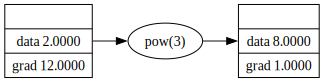

In [138]:
a = Value(2.0)
b = a ** 3


b.backward()

draw_dot(b)

In [139]:
a = Value(4.0)
b = Value(2.0)

c = a / b
c.backward()

print(a.grad, b.grad)

0.5 -1.0


In [140]:
from graphviz import Digraph

def trace(root: Value):
    nodes, edges = set(), set()
    
    def build(v: Value):
        if v not in nodes:
            nodes.add(v)
            
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={ 'rankdir': 'LR' })
    nodes, edges = trace(root)
    
    
    for node in nodes:
        uid = str(id(node))
        # print(node)
        dot.node(name=uid, label=f"{node.label}|data {node.data:.4f}|grad {node.grad:.4f}", shape='record')
        if node._op:
            # this value was generated as a result of some operation, create an operation node
            
            dot.node(name=uid + node._op, label=node._op)
            dot.edge(uid + node._op, uid)
            
    for n1, n2 in edges:
        # print("edge", n1, n2)
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [141]:
# demo neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.88137, label="b")

x1w1 = (x1 * w1).setLabel('x1 * w1')
x2w2 = (x2 * w2).setLabel('x2 * w2')

x1w1x2w2 = (x1w1 + x2w2).setLabel('x1*w1 + x2*w2')

n = (x1w1x2w2 + b).setLabel("n")

o = n.tanh().setLabel("output")


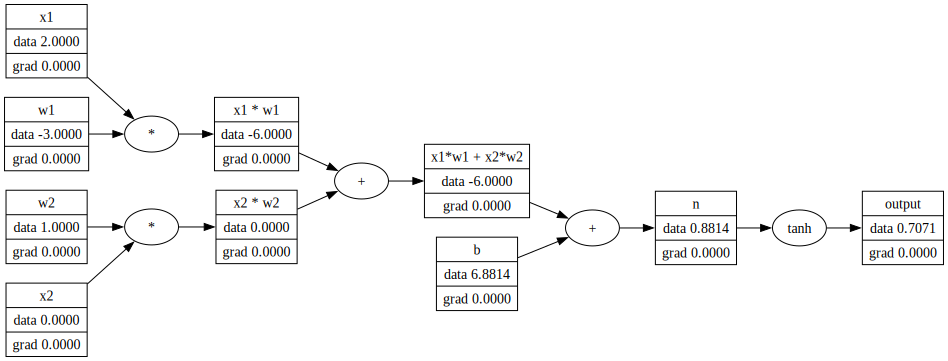

In [142]:
draw_dot(o)

In [143]:
o.backward()